In [1]:
%conda info


     active environment : /project/vitelli/ml_venv
    active env location : /project/vitelli/ml_venv
            shell level : 4
       user config file : /home/jcolen/.condarc
 populated config files : 
          conda version : 23.1.0
    conda-build version : 3.23.3
         python version : 3.9.12.final.0
       virtual packages : __archspec=1=x86_64
                          __cuda=11.8=0
                          __glibc=2.28=0
                          __linux=4.18.0=0
                          __unix=0=0
       base environment : /software/python-anaconda-2022.05-el8-x86_64  (read only)
      conda av data dir : /software/python-anaconda-2022.05-el8-x86_64/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

In [3]:
from data_processing import *
from pbnn import *
from torch.utils.data import ConcatDataset

def plot(ax, sample, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    

housing_method='constant'
dataset = ConcatDataset([
    CensusDataset('cook_IL',housing_method=housing_method),
    CensusDataset('fulton_GA',housing_method=housing_method),
    CensusDataset('harris_TX',housing_method=housing_method),
    CensusDataset('la_CA',housing_method=housing_method),
    CensusDataset('wayne_MI',housing_method=housing_method),
])
fig, ax = plt.subplots(2, 5, dpi=150)
for i, ds in enumerate(dataset.datasets):
    ds.validate()
    plot(ax[:, i], dataset[i*40])
    
ax[0,0].set_ylabel(f'White')
ax[1,0].set_ylabel(f'Black')

fig, ax = plt.subplots(2, 5, dpi=150)
for i, ds in enumerate(dataset.datasets):
    ds.validate()
    plot(ax[:, i], dataset[i*40+30])
    
ax[0,0].set_ylabel(f'White')
ax[1,0].set_ylabel(f'Black')

ModuleNotFoundError: No module named 'ufl'

Building dataset with constant housing in time


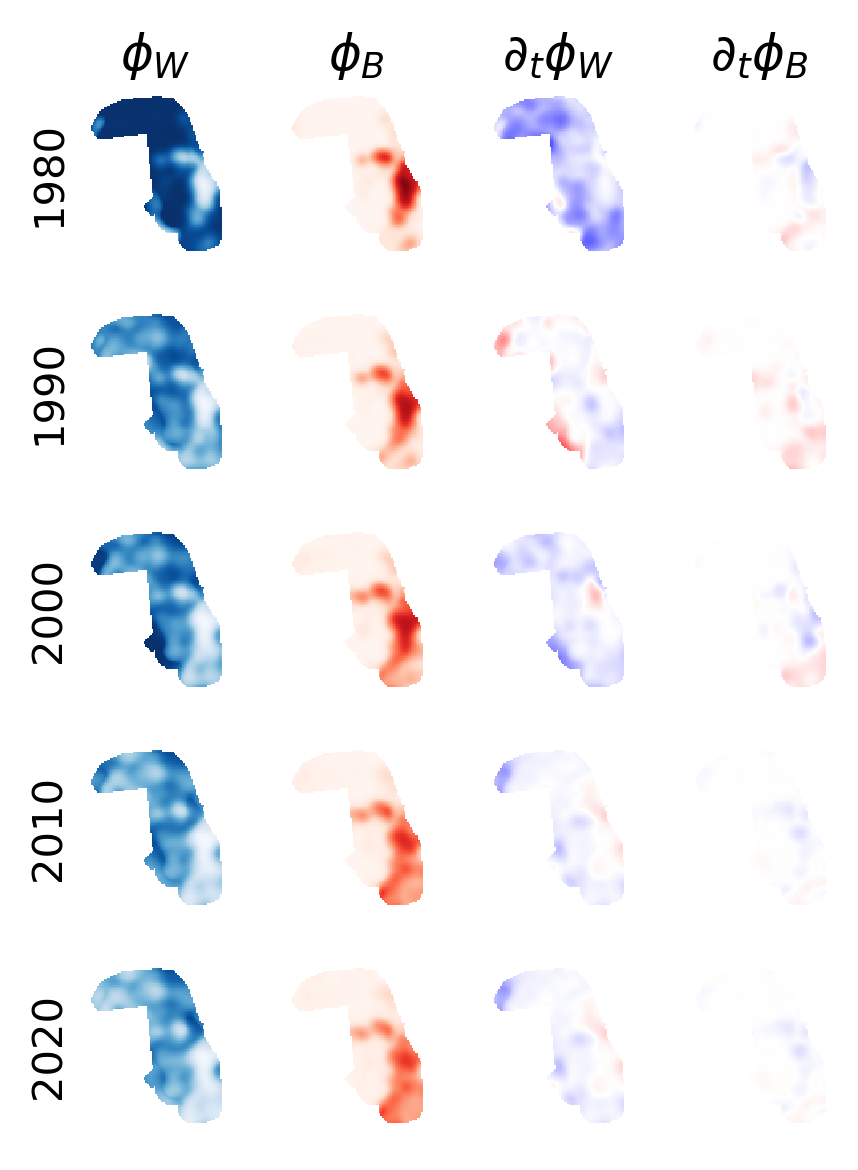

In [17]:
fig, ax = plt.subplots(5, 4, figsize=(3, 4), dpi=300)

county = 'cook_IL'
dataset = CensusDataset(county, housing_method='constant')
dataset.validate()

vmax = 0.1
for i in range(5):
    wb0 = dataset.wb(1980+i*10)
    wb1 = dataset.wb(1980+i*10+1)
    ax[i, 0].pcolormesh(dataset.x, dataset.y, wb0[0], vmin=0, vmax=1, cmap='Blues')
    ax[i, 1].pcolormesh(dataset.x, dataset.y, wb0[1], vmin=0, vmax=1, cmap='Reds')
    ax[i, 2].pcolormesh(dataset.x, dataset.y, wb1[0]-wb0[0], vmin=-vmax, vmax=vmax, cmap='bwr')
    ax[i, 3].pcolormesh(dataset.x, dataset.y, wb1[1]-wb0[1], vmin=-vmax, vmax=vmax, cmap='bwr')
    ax[i,0].set_ylabel(1980+i*10)

for a in ax.flatten():
    a.set(xticks=[], yticks=[], aspect='equal')
    
ax[0,0].set_title('$\phi_W$')
ax[0,1].set_title('$\phi_B$')
ax[0,2].set_title('$\partial_t \phi_W$')
ax[0,3].set_title('$\partial_t \phi_B$')
    
plt.tight_layout()

# Plotting BWR maps of "All White" -> "All Black"

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

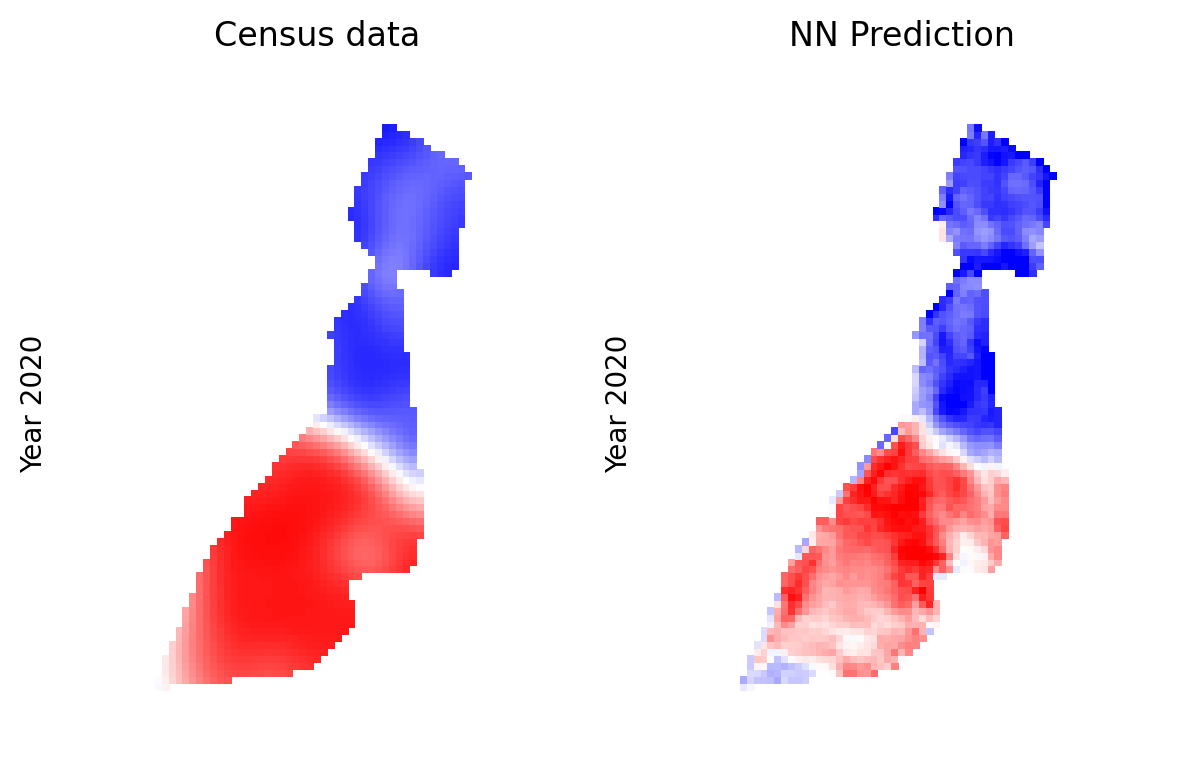

In [18]:
plt.rcParams['axes.linewidth'] = 0

def plot(ax, sample, savename=None):
    w = sample['wb0'][0] * dataset.housing
    b = sample['wb0'][1] * dataset.housing
    if savename is not None:
        np.save(savename, sample['wb0'] * dataset.housing)
    toplot = (w - b) / (w + b)
    ax.pcolormesh(sample['x'], sample['y'], toplot, vmin=-1, vmax=1, cmap='bwr_r')
    ax.set(
        xticks=[],
        yticks=[],
        aspect='equal',
        ylabel=f'Year {sample["t"]:g}'
    )

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'fulton_GA'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(1, 2, dpi=200)

plot(ax[0], dataset[tmax], savename=f'data/{county}/{county}_CensusData')
np.save(f'data/{county}_X', dataset.x)
np.save(f'data/{county}_Y', dataset.y)
np.save(f'data/{county}_mask', dataset.mask)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[1], sample, savename=f'data/{county}/{county}_NNPred')
plot(ax[1], sample)
ax[0].set_title('Census data')
ax[1].set_title('NN Prediction')

plt.tight_layout()

plt.savefig(f'PBNN_Prediction_{county}.svg')

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

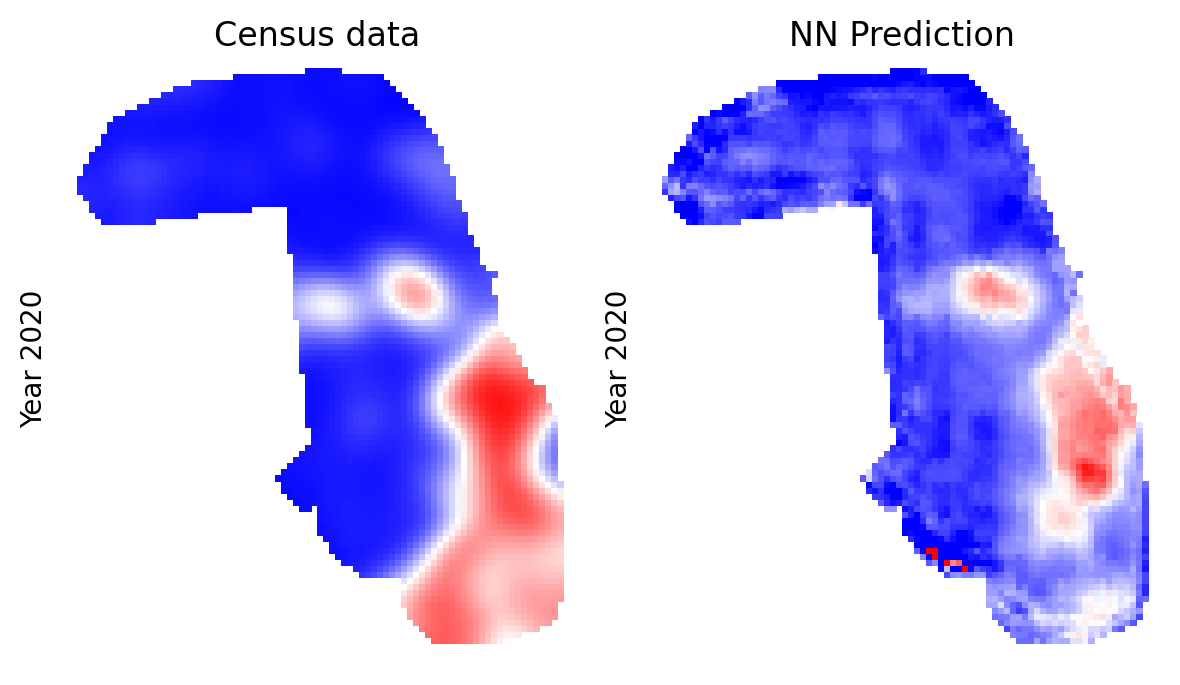

In [19]:
def plot(ax, sample, savename=None):
    w = sample['wb0'][0] * dataset.housing
    b = sample['wb0'][1] * dataset.housing
    if savename is not None:
        np.save(savename, sample['wb0'] * dataset.housing)
    toplot = (w - b) / (w + b)
    ax.pcolormesh(sample['x'], sample['y'], toplot, vmin=-1, vmax=1, cmap='bwr_r')
    ax.set(
        xticks=[],
        yticks=[],
        aspect='equal',
        ylabel=f'Year {sample["t"]:g}'
    ) 

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'cook_IL'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(1, 2, dpi=200)

plot(ax[0], dataset[tmax], savename=f'data/{county}/{county}_CensusData')
np.save(f'data/{county}_X', dataset.x)
np.save(f'data/{county}_Y', dataset.y)
np.save(f'data/{county}_mask', dataset.mask)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[1], sample, savename=f'data/{county}/{county}_NNPred')
plot(ax[1], sample)
ax[0].set_title('Census data')
ax[1].set_title('NN Prediction')

plt.tight_layout()

plt.savefig(f'PBNN_Prediction_{county}.svg')

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

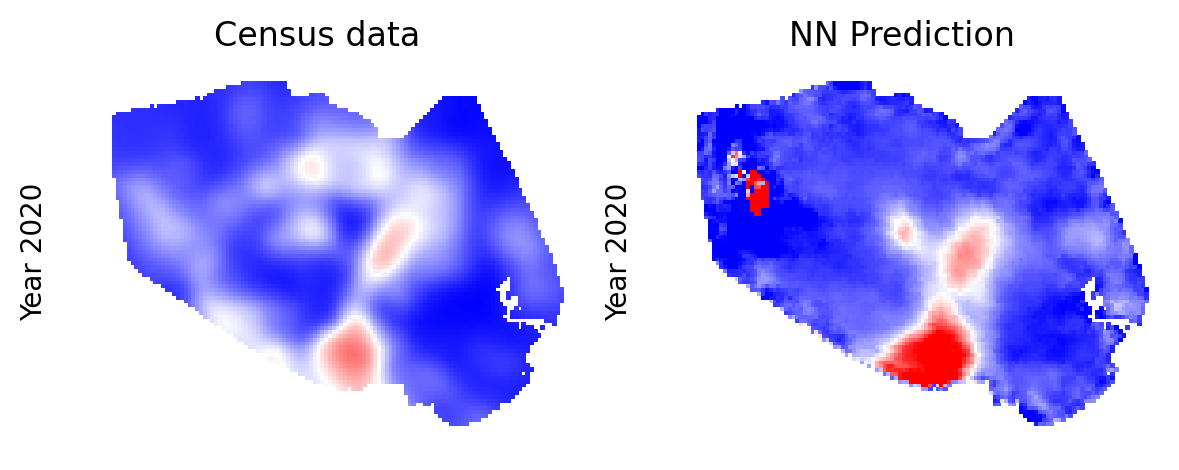

In [20]:
def plot(ax, sample, savename=None):
    w = sample['wb0'][0] * dataset.housing
    b = sample['wb0'][1] * dataset.housing
    if savename is not None:
        np.save(savename, sample['wb0'] * dataset.housing)
    toplot = (w - b) / (w + b)
    ax.pcolormesh(sample['x'], sample['y'], toplot, vmin=-1, vmax=1, cmap='bwr_r')
    ax.set(
        xticks=[],
        yticks=[],
        aspect='equal',
        ylabel=f'Year {sample["t"]:g}'
    )

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'harris_TX'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(1, 2, dpi=200)

plot(ax[0], dataset[tmax], savename=f'data/{county}/{county}_CensusData')
np.save(f'data/{county}_X', dataset.x)
np.save(f'data/{county}_Y', dataset.y)
np.save(f'data/{county}_mask', dataset.mask)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[1], sample, savename=f'data/{county}/{county}_NNPred')
plot(ax[1], sample)
ax[0].set_title('Census data')
ax[1].set_title('NN Prediction')

plt.tight_layout()

plt.savefig(f'PBNN_Prediction_{county}.svg')

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

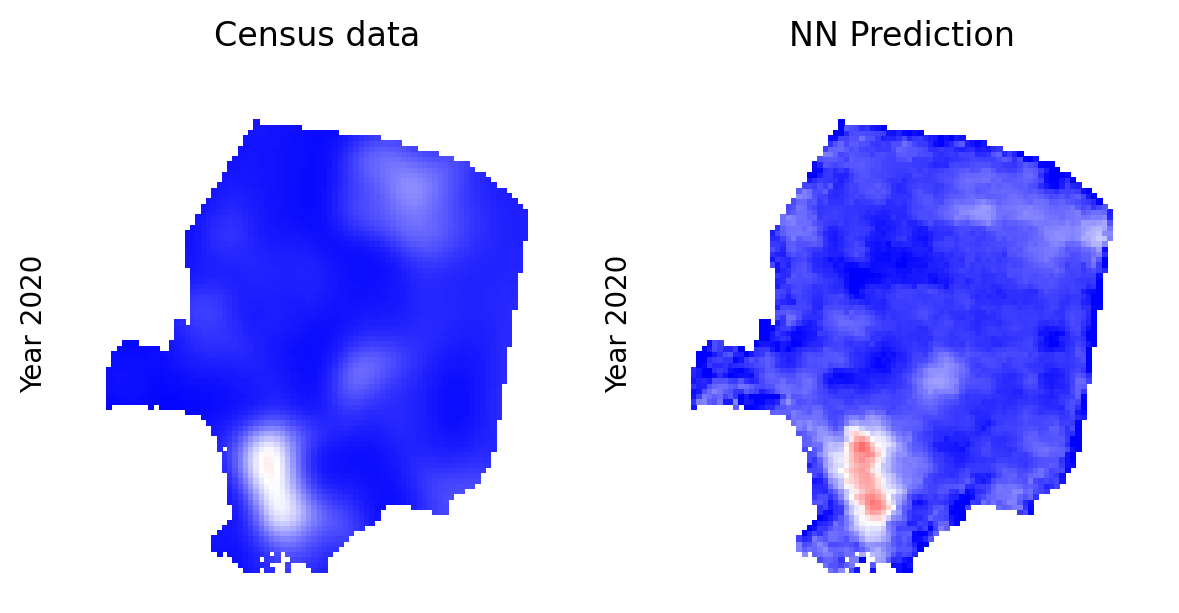

In [21]:
def plot(ax, sample, savename=None):
    w = sample['wb0'][0] * dataset.housing
    b = sample['wb0'][1] * dataset.housing
    if savename is not None:
        np.save(savename, sample['wb0'] * dataset.housing)
    toplot = (w - b) / (w + b)
    ax.pcolormesh(sample['x'], sample['y'], toplot, vmin=-1, vmax=1, cmap='bwr_r')
    ax.set(
        xticks=[],
        yticks=[],
        aspect='equal',
        ylabel=f'Year {sample["t"]:g}'
    )

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'la_CA'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(1, 2, dpi=200)

plot(ax[0], dataset[tmax], savename=f'data/{county}/{county}_CensusData')
np.save(f'data/{county}_X', dataset.x)
np.save(f'data/{county}_Y', dataset.y)
np.save(f'data/{county}_mask', dataset.mask)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[1], sample, savename=f'data/{county}/{county}_NNPred')
plot(ax[1], sample)
ax[0].set_title('Census data')
ax[1].set_title('NN Prediction')

plt.tight_layout()

plt.savefig(f'PBNN_Prediction_{county}.svg')

# Plotting dynamics of white and black

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

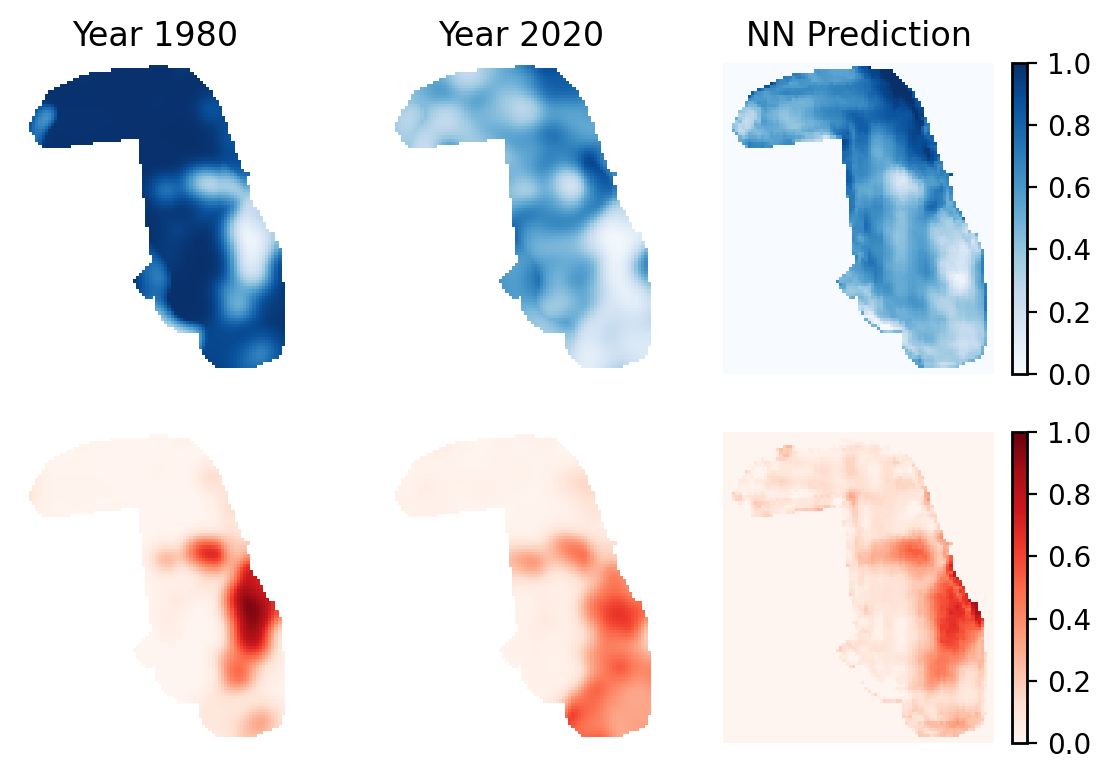

In [29]:
def plot(ax, sample, housing=None, vmax=1, colorbar=False):
    if housing is not None:
        sample['wb0'] *= housing
    imW = ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=vmax, vmin=0)
    imB = ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=vmax, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_title(f'Year {sample["t"]:g}')
    if colorbar:
        cax1 = plt.colorbar(imW, ax=ax[0])
        cax2 = plt.colorbar(imB, ax=ax[1])
    ax[0].axis('off')
    ax[1].axis('off')

from data_processing import *
from pbnn import *
from dolfin_problems import *

plt.rcParams['axes.linewidth'] = 1

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1


county = 'cook_IL'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

fig, ax = plt.subplots(2, 3, dpi=200)

plot(ax[:, 0], dataset[0])#, dataset.housing, vmax=8000)
plot(ax[:, 1], dataset[tmax])#, dataset.housing, vmax=8000)
sample = dataset[0]
with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[:, 2], sample, colorbar=True)#, dataset.housing, vmax=8000, colorbar=True)
ax[0, 2].set_title('NN Prediction')

ax[0,0].set_ylabel('White')
ax[1,0].set_ylabel('Black')
plt.tight_layout()

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

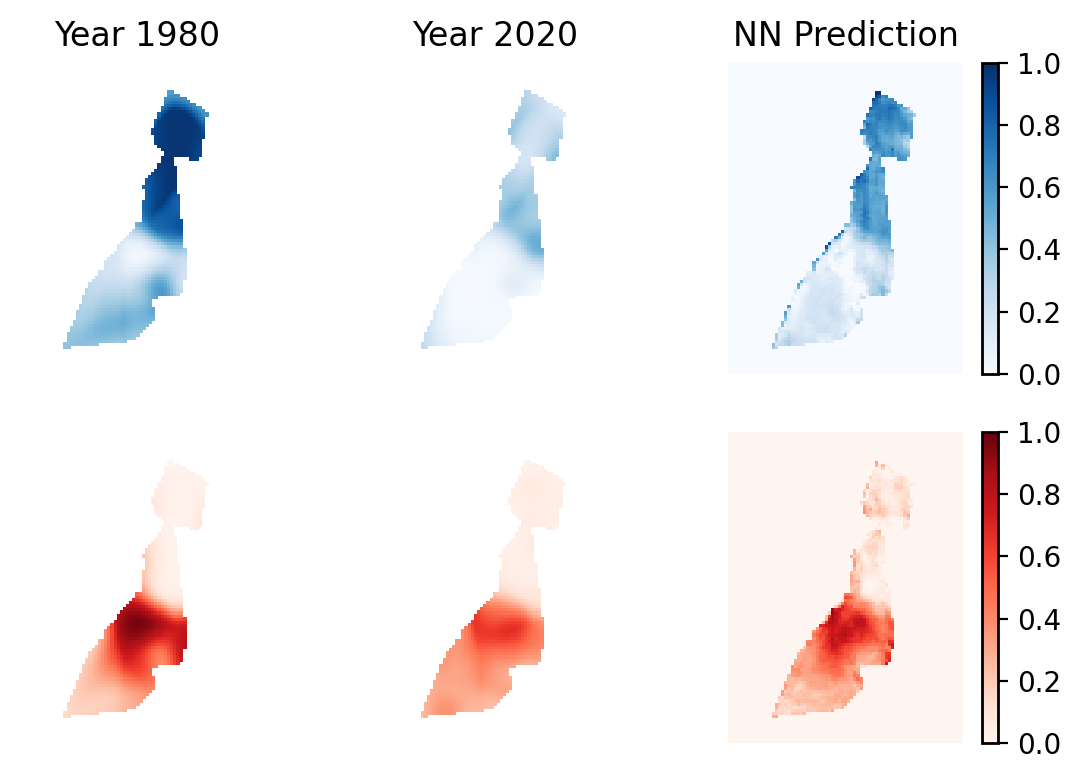

In [28]:
def plot(ax, sample, housing=None, vmax=1, colorbar=False):
    if housing is not None:
        sample['wb0'] *= housing
    imW = ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=vmax, vmin=0)
    imB = ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=vmax, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_title(f'Year {sample["t"]:g}')
    if colorbar:
        cax1 = plt.colorbar(imW, ax=ax[0])
        cax2 = plt.colorbar(imB, ax=ax[1])
    ax[0].axis('off')
    ax[1].axis('off')

from data_processing import *
from pbnn import *
from dolfin_problems import *

plt.rcParams['axes.linewidth'] = 1

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1


county = 'fulton_GA'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

fig, ax = plt.subplots(2, 3, dpi=200)

plot(ax[:, 0], dataset[0])
plot(ax[:, 1], dataset[tmax])
sample = dataset[0]
with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[:, 2], sample, colorbar=True)
ax[0, 2].set_title('NN Prediction')

ax[0,0].set_ylabel('White')
ax[1,0].set_ylabel('Black')
plt.tight_layout()

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

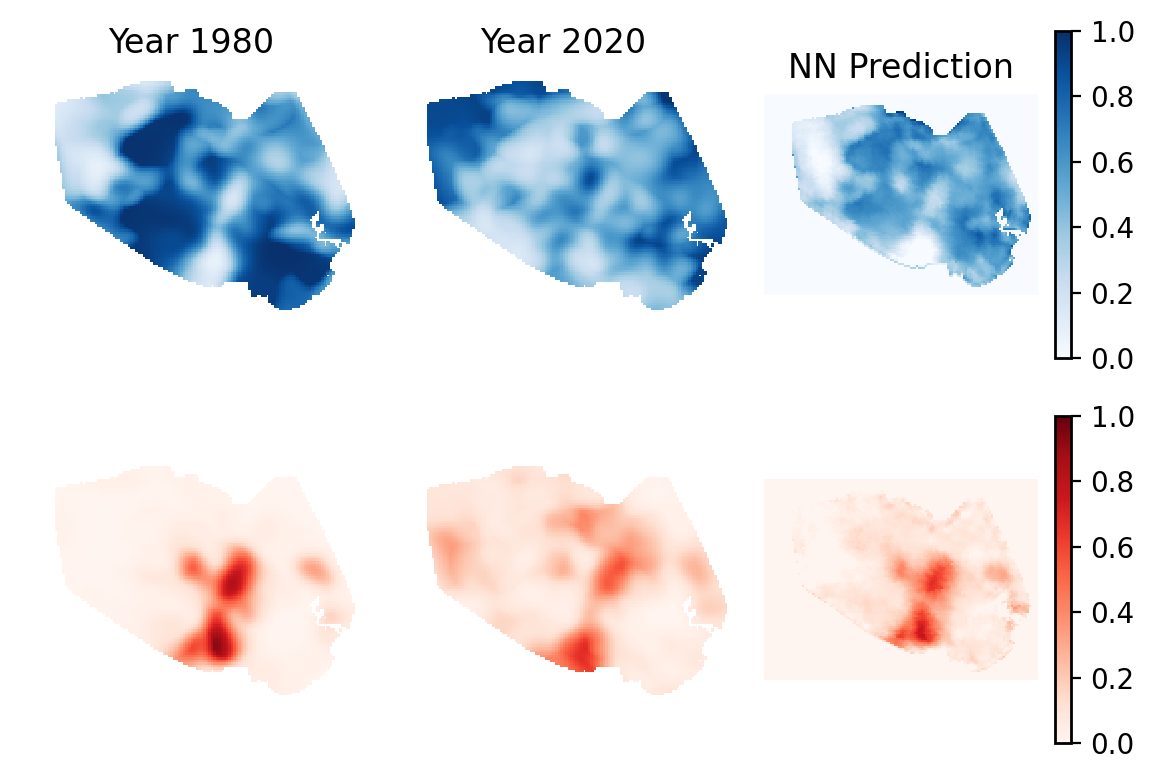

In [22]:
def plot(ax, sample, housing=None, vmax=1, colorbar=False):
    if housing is not None:
        sample['wb0'] *= housing
    imW = ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=vmax, vmin=0)
    imB = ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=vmax, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_title(f'Year {sample["t"]:g}')
    if colorbar:
        cax1 = plt.colorbar(imW, ax=ax[0])
        cax2 = plt.colorbar(imB, ax=ax[1])
    ax[0].axis('off')
    ax[1].axis('off')

from data_processing import *
from pbnn import *
from dolfin_problems import *

plt.rcParams['axes.linewidth'] = 1

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1


county = 'harris_TX'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

fig, ax = plt.subplots(2, 3, dpi=200)

plot(ax[:, 0], dataset[0])
plot(ax[:, 1], dataset[tmax])
sample = dataset[0]
with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[:, 2], sample, colorbar=True)
ax[0, 2].set_title('NN Prediction')

ax[0,0].set_ylabel('White')
ax[1,0].set_ylabel('Black')
plt.tight_layout()

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

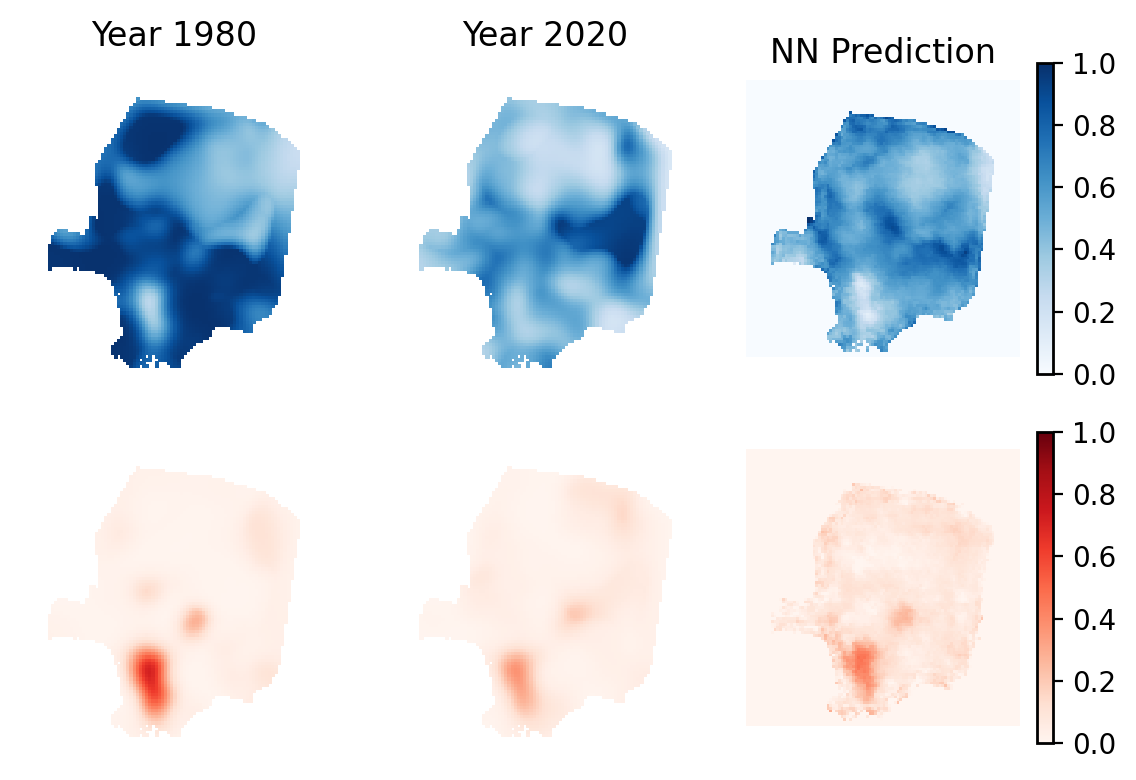

In [23]:
def plot(ax, sample, housing=None, vmax=1, colorbar=False):
    if housing is not None:
        sample['wb0'] *= housing
    imW = ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=vmax, vmin=0)
    imB = ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=vmax, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_title(f'Year {sample["t"]:g}')
    if colorbar:
        cax1 = plt.colorbar(imW, ax=ax[0])
        cax2 = plt.colorbar(imB, ax=ax[1])
    ax[0].axis('off')
    ax[1].axis('off')

from data_processing import *
from pbnn import *
from dolfin_problems import *

plt.rcParams['axes.linewidth'] = 1

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1


county = 'la_CA'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

fig, ax = plt.subplots(2, 3, dpi=200)

plot(ax[:, 0], dataset[0])
plot(ax[:, 1], dataset[tmax])
sample = dataset[0]
with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

plot(ax[:, 2], sample, colorbar=True)
ax[0, 2].set_title('NN Prediction')

ax[0,0].set_ylabel('White')
ax[1,0].set_ylabel('Black')
plt.tight_layout()

# Plotting dynamics + sources

Building dataset with constant housing in time
Si vmax = 0.0323174
Si vmax = 0.0224821


  0%|          | 0/40 [00:00<?, ?it/s]

Si vmax = 0.0268871
Target change after 40 years is: 0.112917
Predicted change after 40 years is: 0.0814416
MSE after 40 years is: 0.0297689


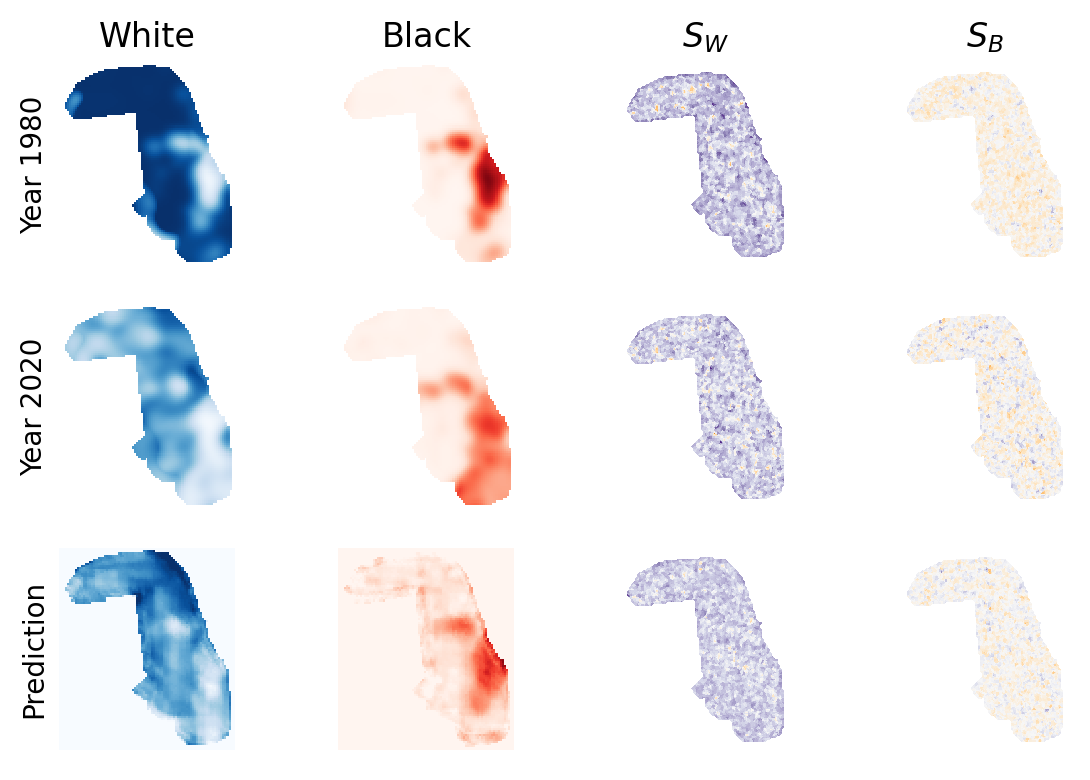

In [9]:
def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        params = model.forward(sample['wb0'][None],
                               sample['problem'].FctSpace,
                               (sample['x'], sample['y']))
        Dij = params['Dij'].detach().cpu().numpy()
        Si  = params['Si'].detach().cpu().numpy()
    
    vmax = np.max(np.abs(Si))
    print(f'Si vmax = {vmax:g}')
    for i in range(2):
        plot_mesh(ax[2+i], Si[i], dataset.mesh, cmap='PuOr', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'cook_IL'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

pipeline=9112009
#model = SourcedSymmetricPBNN().to(device)
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(3, 4, dpi=200)

wb0, Dij0 = plot(ax[0], sample, model)
wb1, Dij1 = plot(ax[1], dataset[tmax], model)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb2, Dij2 = plot(ax[2], sample, model)
ax[2,0].set_ylabel('Prediction')

print(f'Target change after {tmax} years is: {np.mean((wb1[:, mask]-wb0[:, mask])**2):g}')
print(f'Predicted change after {tmax} years is: {np.mean((wb2[:, mask]-wb0[:, mask])**2):g}')
print(f'MSE after {tmax} years is: {np.mean((wb2[:, mask]-wb1[:, mask])**2):g}')

ax[0,0].set_title('White')
ax[0,1].set_title('Black')
ax[0,2].set_title('$S_{W}$')
ax[0,3].set_title('$S_{B}$')

plt.tight_layout()

Building dataset with constant housing in time
Si vmax = 0.0223148
Si vmax = 0.0395167


  0%|          | 0/40 [00:00<?, ?it/s]

Si vmax = 0.0164545
Target change after 40 years is: 0.0820564
Predicted change after 40 years is: 0.040647
MSE after 40 years is: 0.0556388


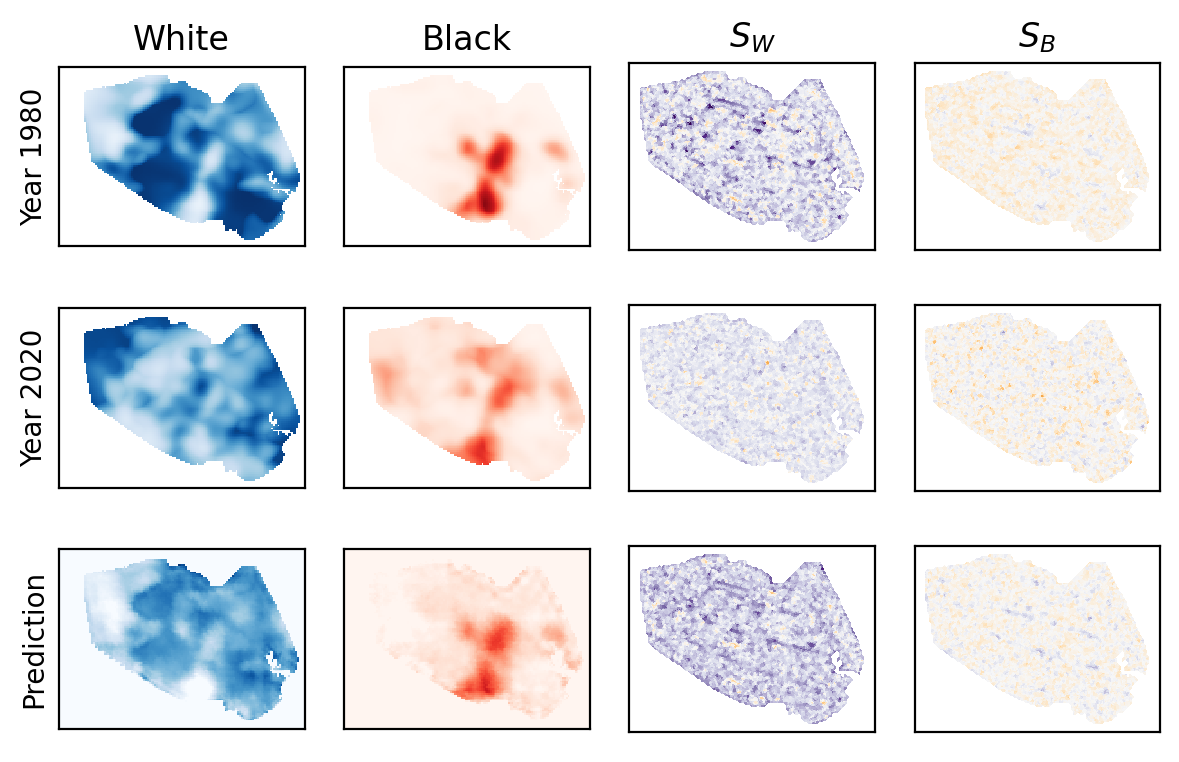

In [7]:
def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        params = model.forward(sample['wb0'][None],
                               sample['problem'].FctSpace,
                               (sample['x'], sample['y']))
        Dij = params['Dij'].detach().cpu().numpy()
        Si  = params['Si'].detach().cpu().numpy()
    
    vmax = np.max(np.abs(Si))
    print(f'Si vmax = {vmax:g}')
    for i in range(2):
        plot_mesh(ax[2+i], Si[i], dataset.mesh, cmap='PuOr', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'harris_TX'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(3, 4, dpi=200)

wb0, Dij0 = plot(ax[0], sample, model)
wb1, Dij1 = plot(ax[1], dataset[tmax], model)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb2, Dij2 = plot(ax[2], sample, model)
ax[2,0].set_ylabel('Prediction')

print(f'Target change after {tmax} years is: {np.mean((wb1[:, mask]-wb0[:, mask])**2):g}')
print(f'Predicted change after {tmax} years is: {np.mean((wb2[:, mask]-wb0[:, mask])**2):g}')
print(f'MSE after {tmax} years is: {np.mean((wb2[:, mask]-wb1[:, mask])**2):g}')

ax[0,0].set_title('White')
ax[0,1].set_title('Black')
ax[0,2].set_title('$S_{W}$')
ax[0,3].set_title('$S_{B}$')

plt.tight_layout()

Building dataset with constant housing in time
Si vmax = 0.0170292
Si vmax = 0.0232013


  0%|          | 0/40 [00:00<?, ?it/s]

Si vmax = 0.0109368
Target change after 40 years is: 0.10674
Predicted change after 40 years is: 0.0514392
MSE after 40 years is: 0.0302253


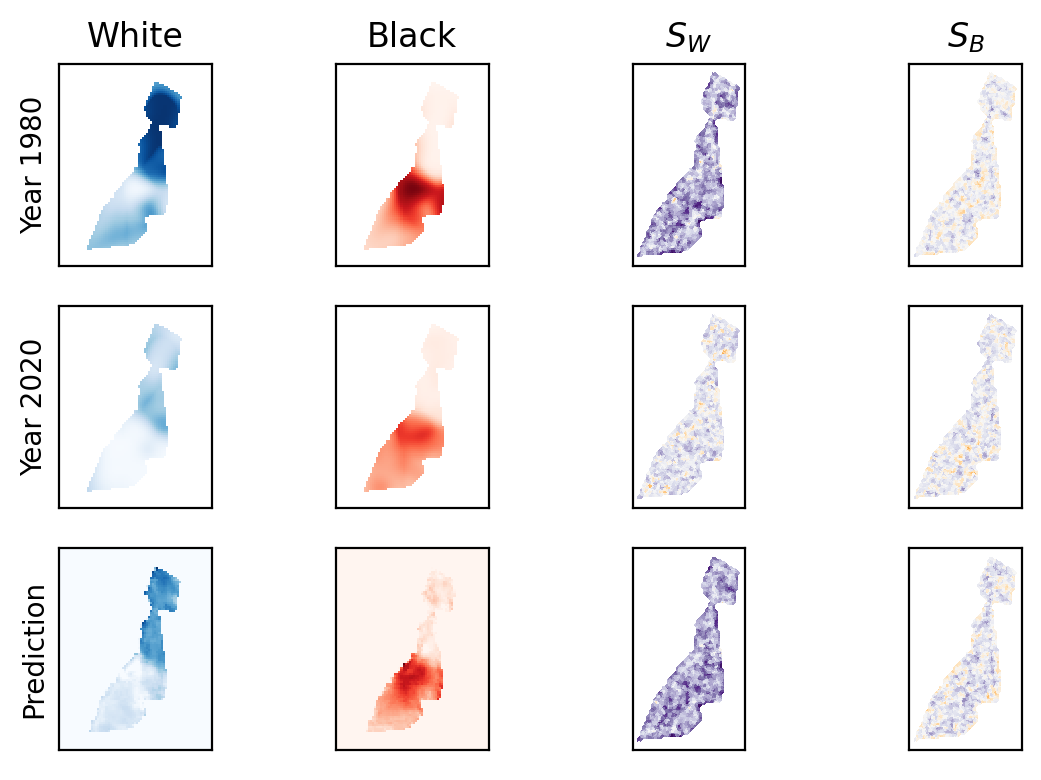

In [19]:
def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        params = model.forward(sample['wb0'][None],
                               sample['problem'].FctSpace,
                               (sample['x'], sample['y']))
        Dij = params['Dij'].detach().cpu().numpy()
        Si  = params['Si'].detach().cpu().numpy()
    
    vmax = np.max(np.abs(Si))
    print(f'Si vmax = {vmax:g}')
    for i in range(2):
        plot_mesh(ax[2+i], Si[i], dataset.mesh, cmap='PuOr', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'fulton_GA'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(3, 4, dpi=200)

wb0, Dij0 = plot(ax[0], sample, model)
wb1, Dij1 = plot(ax[1], dataset[tmax], model)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb2, Dij2 = plot(ax[2], sample, model)
ax[2,0].set_ylabel('Prediction')

print(f'Target change after {tmax} years is: {np.mean((wb1[:, mask]-wb0[:, mask])**2):g}')
print(f'Predicted change after {tmax} years is: {np.mean((wb2[:, mask]-wb0[:, mask])**2):g}')
print(f'MSE after {tmax} years is: {np.mean((wb2[:, mask]-wb1[:, mask])**2):g}')

ax[0,0].set_title('White')
ax[0,1].set_title('Black')
ax[0,2].set_title('$S_{W}$')
ax[0,3].set_title('$S_{B}$')

plt.tight_layout()

Building dataset with constant housing in time
Si vmax = 0.0222402
Si vmax = 0.0183581


  0%|          | 0/40 [00:00<?, ?it/s]

Si vmax = 0.0126571
Target change after 40 years is: 0.0698236
Predicted change after 40 years is: 0.0389359
MSE after 40 years is: 0.0199327


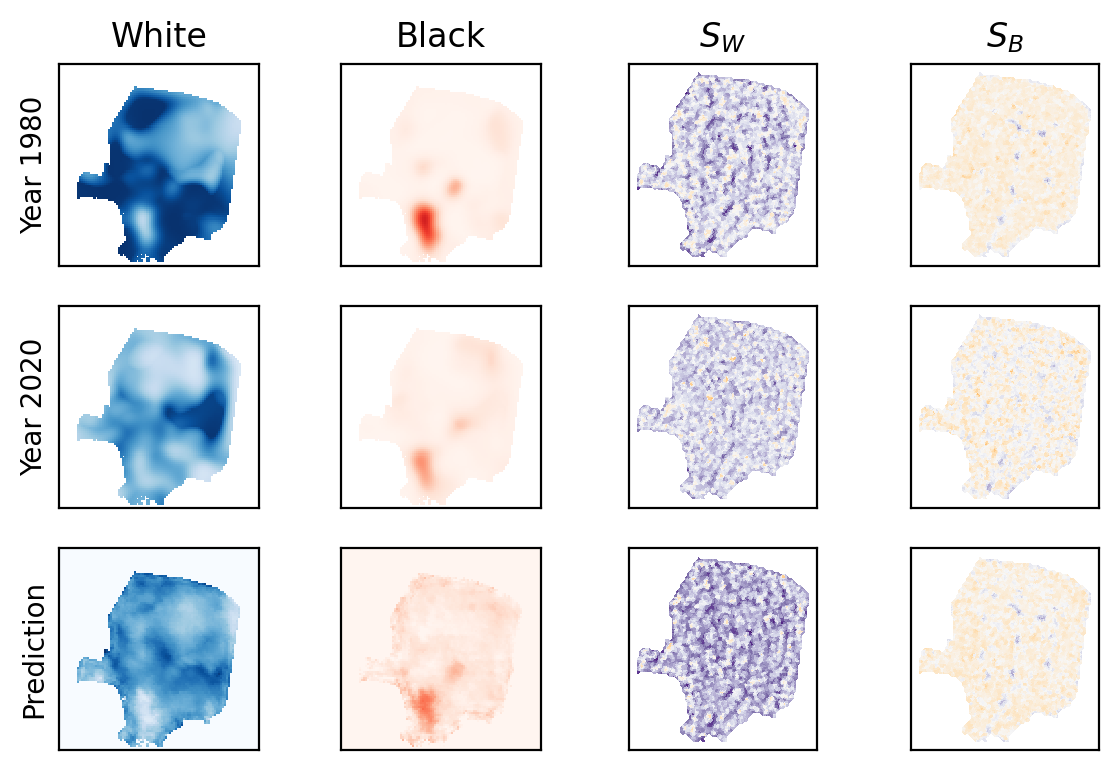

In [20]:
def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        params = model.forward(sample['wb0'][None],
                               sample['problem'].FctSpace,
                               (sample['x'], sample['y']))
        Dij = params['Dij'].detach().cpu().numpy()
        Si  = params['Si'].detach().cpu().numpy()
    
    vmax = np.max(np.abs(Si))
    print(f'Si vmax = {vmax:g}')
    for i in range(2):
        plot_mesh(ax[2+i], Si[i], dataset.mesh, cmap='PuOr', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'la_CA'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

pipeline=9112009
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(3, 4, dpi=200)

wb0, Dij0 = plot(ax[0], sample, model)
wb1, Dij1 = plot(ax[1], dataset[tmax], model)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb2, Dij2 = plot(ax[2], sample, model)
ax[2,0].set_ylabel('Prediction')

print(f'Target change after {tmax} years is: {np.mean((wb1[:, mask]-wb0[:, mask])**2):g}')
print(f'Predicted change after {tmax} years is: {np.mean((wb2[:, mask]-wb0[:, mask])**2):g}')
print(f'MSE after {tmax} years is: {np.mean((wb2[:, mask]-wb1[:, mask])**2):g}')

ax[0,0].set_title('White')
ax[0,1].set_title('Black')
ax[0,2].set_title('$S_{W}$')
ax[0,3].set_title('$S_{B}$')

plt.tight_layout()

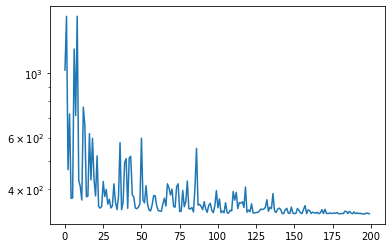

In [18]:
plt.figure()
plt.semilogy(info['val_loss'])

# Build a spatial saliency map

In [8]:
def forward(model, wb0, FctSpace, xy):
    #Neural network part
    x = model.read_in(wb0)
    for cell in model.cnn1:
        x = x + cell(x)
    latent = model.downsample(x)
    for cell in model.cnn2:
        latent = latent + cell(latent)
    latent = F.interpolate(latent, x.shape[-2:])
    x = torch.cat([x, latent], dim=1)
    DS = model.read_out(x).squeeze()

    #Separate data and postprocess
    D = DS[:4]
    S = DS[4:]
    
    return {
        'Dij': D,
        'Si': S,
        'Gammas': model.gammas.exp()
    }

def aggregate_sample(model, sample):
    sample['wb0'] = sample['wb0'].to(device)[None]
    sample['wb0'][sample['wb0'].isnan()] = 0
    sample['wb0'].requires_grad = True
    params = forward(
        model,
        sample['wb0'],
        sample['problem'].FctSpace,
        (sample['x'], sample['y']))

    nnz = np.asarray(np.nonzero(sample['mask'])).T
    np.random.shuffle(nnz)
    pts = nnz[:100]

    G_D = []
    G_S = []
    for pt in pts:
        loc = torch.zeros_like(params['Dij'][0])
        loc[pt[0], pt[1]] = 1.
        
        grad = []
        for j in range(params['Dij'].shape[0]):
            grad.append(torch.autograd.grad(params['Dij'][j], sample['wb0'], grad_outputs=loc, retain_graph=True)[0])
        grad = torch.stack(grad) #[4, 2, Y, X]
        G_D.append(grad.detach().cpu().numpy().squeeze())

        grad = []
        for j in range(params['Si'].shape[0]):
            grad.append(torch.autograd.grad(params['Si'][j], sample['wb0'], grad_outputs=loc, retain_graph=True)[0])
        grad = torch.stack(grad) #[2, 2, Y, X]
        G_S.append(grad.detach().cpu().numpy().squeeze())
    
    center = np.asarray([G_S[0].shape[-2]/2, G_S[0].shape[-1]/2]).astype(int)
    shifts = np.asarray(center-pts)

    G_D_shifted = np.asarray([np.roll(g, shift, axis=(-2,-1)) for shift, g in zip(shifts, G_D)])
    G_S_shifted = np.asarray([np.roll(g, shift, axis=(-2,-1)) for shift, g in zip(shifts, G_S)])

    return G_D_shifted, G_S_shifted

import h5py
from tqdm.auto import tqdm

pipeline=9112009
modeltype = SourcedSymmetricPBNN
modeltype = SourcedOnlyPBNN

model = modeltype().to(device)
info = torch.load(f'data/pipeline_{pipeline}/constant/{modeltype.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()
dataset = ConcatDataset([
    CensusDataset('cook_IL',housing_method=housing_method),
    CensusDataset('fulton_GA',housing_method=housing_method),
    CensusDataset('harris_TX',housing_method=housing_method),
    CensusDataset('la_CA',housing_method=housing_method),
])
for ds in dataset.datasets:
    ds.validate()

with h5py.File(f'data/pipeline_{pipeline}/constant/{modeltype.__name__}_saliency.h5', 'w') as h5f:
    gd = h5f.create_group('G_D')
    gs = h5f.create_group('G_S')
    for i in trange(len(dataset)):
        sample = dataset[i]
        G_D, G_S = aggregate_sample(model, sample)
        gd.create_dataset(f'{i:04d}', data=G_D)
        gs.create_dataset(f'{i:04d}', data=G_S)

Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time


  0%|          | 0/160 [00:00<?, ?it/s]

In [27]:
dataset = ConcatDataset([
    CensusDataset('cook_IL',housing_method=housing_method),
    CensusDataset('fulton_GA',housing_method=housing_method),
    CensusDataset('harris_TX',housing_method=housing_method),
    CensusDataset('la_CA',housing_method=housing_method),
])

with h5py.File(f'data/pipeline_{pipeline}/constant/{modeltype.__name__}_saliency.h5', 'r') as h5f:
    gs = h5f['G_S']
    keys = list(gs.keys())
    G_s = []
    X_s = []
    Y_s = []
    ii = 0
    for i in range(4):
        G_s.append(np.sum(np.array([gs[keys[i*40+j]] for j in range(40)]), axis=(0,1)))
        print(G_s[i].shape)
        
        x = dataset.datasets[i].x.copy()
        y = dataset.datasets[i].y.copy()
    
        x -= np.mean(x)
        y -= np.mean(y)
        X_s.append(x)
        Y_s.append(y)
        
        print(G_s[i].shape, X_s[i].shape, Y_s[i].shape)
        
        np.save(f'data/pipeline_{pipeline}/constant/{modeltype.__name__}_{dataset.datasets[i].county}_saliency', G_s[i])
        np.save(f'data/pipeline_{pipeline}/constant/{modeltype.__name__}_{dataset.datasets[i].county}_X', X_s[i])        
        np.save(f'data/pipeline_{pipeline}/constant/{modeltype.__name__}_{dataset.datasets[i].county}_Y', Y_s[i])

Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time
(2, 2, 100, 87)
(2, 2, 100, 87) (100, 87) (100, 87)
(2, 2, 100, 76)
(2, 2, 100, 76) (100, 76) (100, 76)
(2, 2, 100, 137)
(2, 2, 100, 137) (100, 137) (100, 137)
(2, 2, 100, 99)
(2, 2, 100, 99) (100, 99) (100, 99)


In [10]:
print(np.max([np.max(Xi) for Xi in X_s]))
print(np.max([np.max(Yi) for Yi in Y_s]))

66.74173549999978
67.46041854999959


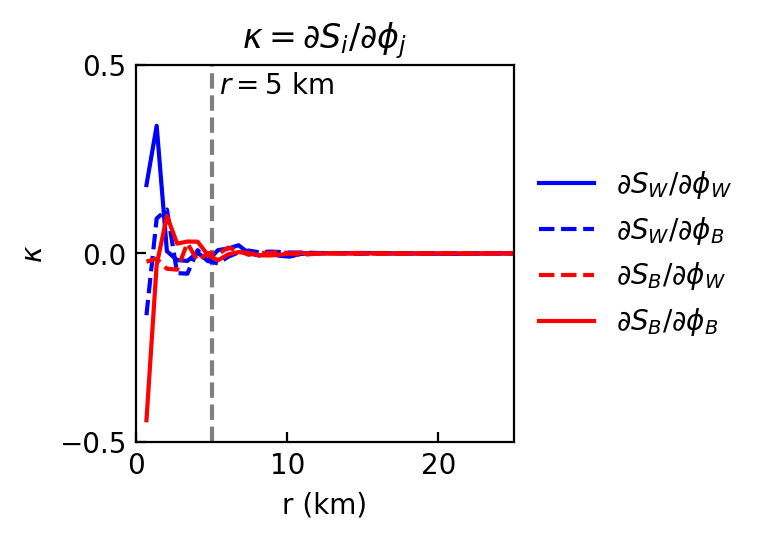

In [32]:
from scipy.interpolate import RectBivariateSpline

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.linspace(0, np.max(rgrid) / np.sqrt(2), 100)
    
    #Compute radial average
    gr = np.zeros(len(r)-1)
    for j in range(len(r)-1):
        gr[j] = np.mean(Gr[(rgrid>=r[j])*(rgrid<r[j+1])])
        
    return r[1:], gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

x = np.linspace(-xmax, xmax, 200)
y = np.linspace(-ymax, ymax, 200)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa$')
ax.set(
    xlim=[0, 25],
    ylim=[-0.5, 0.5],
    xticks=[0, 10, 20],
    yticks=[-0.5, 0, 0.5])
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 5
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.set_title('$\\kappa = \\partial S_i / \\partial \\phi_j$')
ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5])

fig.savefig('PBNN_Census_Saliency.svg', bbox_inches='tight')

67.1020391958883


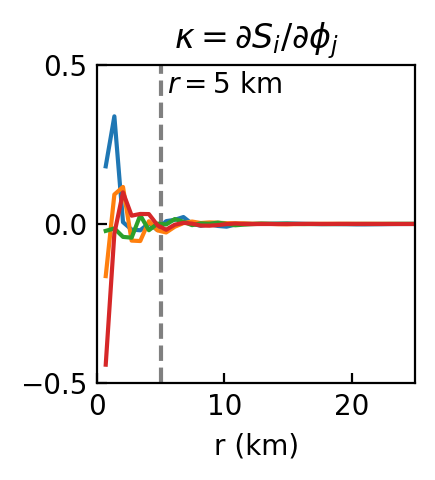

In [19]:
from scipy.interpolate import RectBivariateSpline

def get_Gr(G_s, idx, x, y):

xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

x = np.linspace(-xmax, xmax, 200)
y = np.linspace(-ymax, ymax, 200)
x, y = np.meshgrid(x, y, indexing='xy')

rgrid = np.linalg.norm(np.stack([x, y]), axis=0)
print(np.max(rgrid) / np.sqrt(2))
r = np.linspace(0, np.max(rgrid) / np.sqrt(2), 100)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

labels = ['

for i in range(4):
    Gr = np.zeros(rgrid.shape)
    for j in range(4):
        Gsj = G_s[j][i//2, i%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x[0, :], y[:, 0])
        
    Gr = Gr / (4*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    #Compute radial average
    gr = np.zeros(len(r)-1)
    for j in range(len(r)-1):
        gr[j] = np.mean(Gr[(rgrid>=r[j])*(rgrid<r[j+1])])
    ax.plot(r[1:], gr)

ax.set(xlabel='r (km)')
ax.set(
    xlim=[0, 25],
    ylim=[-0.5, 0.5],
    xticks=[0, 10, 20],
    yticks=[-0.5, 0, 0.5])
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 5
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.set_title('$\\kappa = \\partial S_i / \\partial \\phi_j$')

plt.tight_layout()

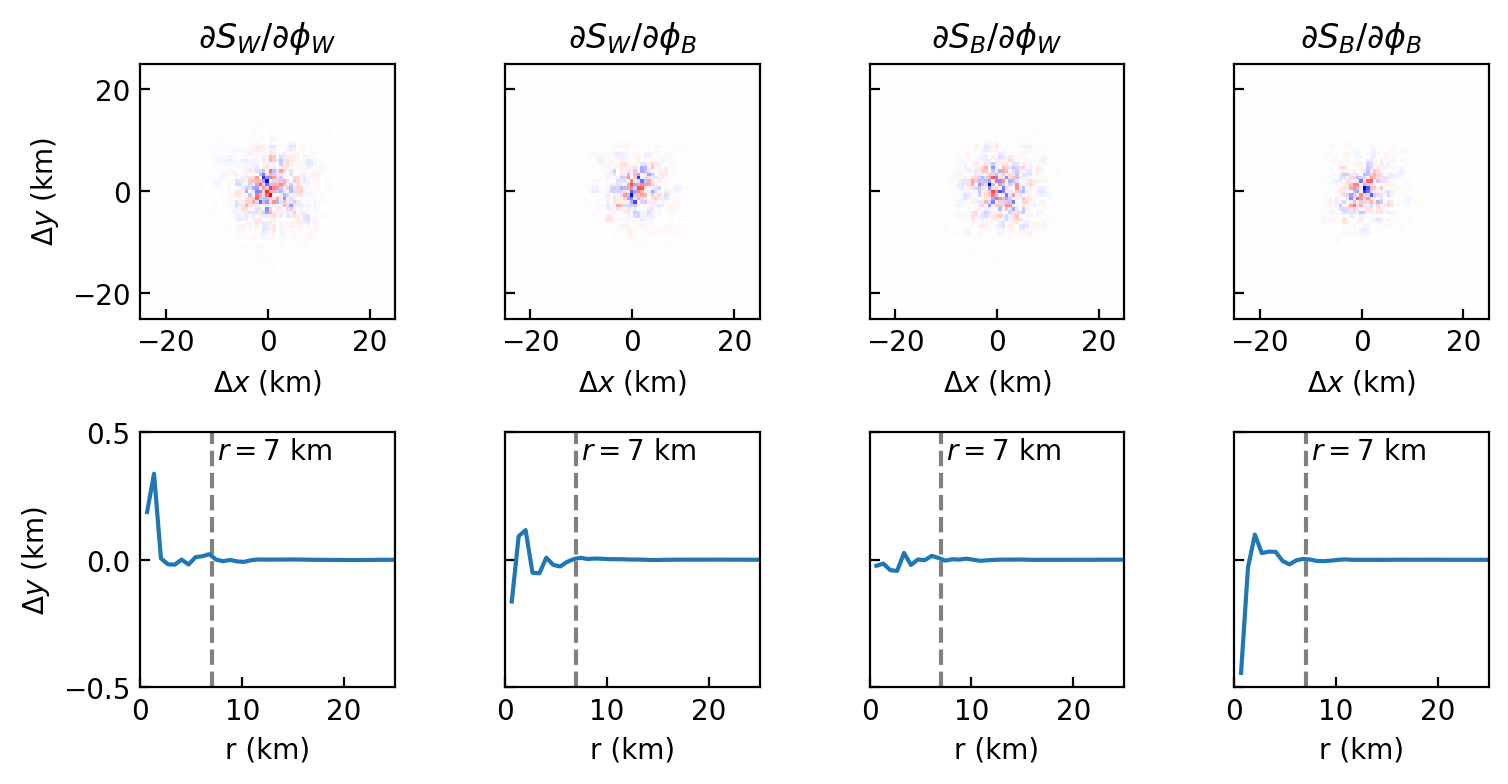

In [56]:
from scipy.interpolate import RectBivariateSpline

xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

x = np.linspace(-xmax, xmax, 200)
y = np.linspace(-ymax, ymax, 200)
x, y = np.meshgrid(x, y, indexing='xy')

rgrid = np.linalg.norm(np.stack([x, y]), axis=0)
r = np.linspace(0, np.max(rgrid) / np.sqrt(2), 100)

fig, ax = plt.subplots(2, 4, figsize=(8, 4), dpi=200, 
                       sharey='row', sharex='row')

for i in range(4):
    Gr = np.zeros(rgrid.shape)
    for j in range(4):
        Gsj = G_s[j][i//2, i%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x[0, :], y[:, 0])
        
    Gr = Gr / (4*40)
    Gr = Gr / np.abs(Gr).max()
    ax[0, i].pcolormesh(x, y, Gr,
                        vmin=-1, vmax=1, cmap='bwr')
    
    ax[0, i].set(
        xlabel=r'$\Delta x$ (km)',
        aspect='equal',
    )
    
    gr = np.zeros(len(r)-1)
    for j in range(len(r)-1):
        gr[j] = np.mean(Gr[(rgrid>=r[j])*(rgrid<r[j+1])])
    ax[1, i].plot(r[1:], gr)
    ax[1, i].set(xlabel='r (km)')
        
for i in range(4):
    ax[0,i].set(
        xlim=[-25, 25],
        ylim=[-25, 25])
    ax[1,i].set(
        xlim=[0, 25],
        ylim=[-0.5, 0.5],
        xticks=[0, 10, 20],
        yticks=[-0.5, 0, 0.5])
    ax[1,i].set_aspect(np.ptp(ax[1,i].get_xlim()) / np.ptp(ax[1,i].get_ylim()))
    
    r0 = 7
    ax[1,i].axvline(r0, linestyle='--', zorder=-1, color='grey')
    ax[1,i].text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
                 transform=ax[1,i].transData)

    ax[0,i].tick_params(which='both', direction='in')
    ax[1,i].tick_params(which='both', direction='in')
    
ax[0,0].set_ylabel(r'$\Delta y$ (km)')
ax[1,0].set_ylabel(r'$\Delta y$ (km)')

ax[0,0].set_title('$\\partial S_W / \\partial \\phi_W$')
ax[0,1].set_title('$\\partial S_W / \\partial \\phi_B$')
ax[0,2].set_title('$\\partial S_B / \\partial \\phi_W$')
ax[0,3].set_title('$\\partial S_B / \\partial \\phi_B$')

plt.tight_layout()